Librerías

In [15]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

Conexión con base de datos

In [16]:
load_dotenv()


user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

url = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine = create_engine(url)

Antes de empezar con el análisis y métricasa RFM, veremos el comportamientos generales de las ordenes

## Análisis de `customers`

In [32]:
query = """SELECT * FROM customers"""
customers = pd.read_sql(query,engine)

In [33]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Valores nulos

In [34]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

### Filas duplicadas

In [43]:
customers[customers.duplicated(keep = False)]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


## Análisis de `orders`

In [17]:
query = """SELECT * FROM orders"""

orders = pd.read_sql(query,engine)

In [44]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


### Valores nulos

In [18]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Quizá la cantidad de valores nulos en `order_delivered_customer_date` se deben a ordenes canceladas o no disponibles (`canceled` o `unavailable`)

In [19]:
orders.groupby('order_status')[['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']].apply(lambda x : x.isna().sum())

,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
order_status,,,
approved,0,2,2
canceled,141,550,619
created,5,5,5
delivered,14,2,8
invoiced,0,314,314
processing,0,301,301
shipped,0,0,1107
unavailable,0,609,609


Aquí vemos que todos los valores faltantes para `order_delivered_customer_date` son para estados de órden no entregada, salvo 8 casos. 

### Filas duplicadas

In [20]:
orders[orders.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


### Errores lógicos

#### Fechas incongruentes

In [55]:
orders_temp_error = orders[orders['order_purchase_timestamp'] > orders['order_delivered_carrier_date']]
len(orders_temp_error)

166

In [59]:
orders_temp_error['time_error'] = orders_temp_error['order_purchase_timestamp'] - orders_temp_error['order_delivered_carrier_date']
orders_temp_error['time_error'].agg(['mean','median','max','min'])

mean     1 days 02:02:22.120481
median   0 days 00:35:59.500000
max           171 days 05:05:53
min             0 days 00:00:24
Name: time_error, dtype: timedelta64[us]

In [69]:
top_errores = orders_temp_error.sort_values(by='time_error', ascending=False)
top_errores[['order_id','order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date','order_delivered_customer_date','time_error']].head()

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,time_error
25883,7c48bb55e8e4f7e56d412e9653db37bc,delivered,2018-07-16 18:40:53,2018-01-26 13:35:00,2018-07-23 20:04:45,171 days 05:05:53
83321,4021cd7611d6d9ce5ffcd24817fc374f,delivered,2018-08-18 11:49:40,2018-08-14 06:22:00,2018-08-29 04:41:53,4 days 05:27:40
67844,db090a16182b263b1e896bb26c6f66cf,delivered,2018-07-13 16:14:08,2018-07-13 13:59:00,2018-07-27 11:34:31,0 days 02:15:08
65452,9711d975b961355b4b5d636857e48498,delivered,2018-06-13 15:23:50,2018-06-13 13:15:00,2018-06-26 00:33:48,0 days 02:08:50
79401,89d32b64af005178b318f76cd60f2c3c,delivered,2018-07-06 11:54:40,2018-07-06 09:48:00,2018-07-10 11:44:45,0 days 02:06:40


Estos errores muy probablemente se deben a confusión

In [70]:
min_errores = orders_temp_error.sort_values(by='time_error', ascending=True)
min_errores[['order_id','order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date','order_delivered_customer_date','time_error']].head()

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,time_error
60308,129b63bc323d7b5b2965a143b2e72cc7,delivered,2018-05-30 14:33:24,2018-05-30 14:33:00,2018-06-08 13:58:41,0 days 00:00:24
21643,f2a150c813c1eb96fd1883c1ed8fd9e5,delivered,2018-06-19 10:14:30,2018-06-19 10:14:00,2018-06-27 17:04:42,0 days 00:00:30
45543,1cb3c680ddf904752646028ee22073a4,delivered,2018-07-27 14:08:38,2018-07-27 14:08:00,2018-08-02 18:56:47,0 days 00:00:38
85758,12e4fbad3ebed6412967a3fd5818c456,delivered,2018-06-13 11:43:43,2018-06-13 11:43:00,2018-06-22 21:32:34,0 days 00:00:43
94035,2ef2818bc1477c39bc32b093812b85e8,delivered,2018-05-28 14:33:54,2018-05-28 14:33:00,2018-06-04 19:33:47,0 days 00:00:54


In [49]:
(orders['order_purchase_timestamp'] > orders['order_delivered_customer_date']).sum()

np.int64(0)

### Análisis de cantidad de compras a lo largo del tiempo

In [ ]:
query_orders_date = """
SELECT 
    o.order_id,
	o.order_purchase_timestamp,
    SUM(p.payment_value) AS total_value
FROM orders o
JOIN order_payments p ON o.order_id = p.order_id
WHERE p.payment_value > 0 AND o.order_status NOT IN ('canceled','unavailable')
GROUP BY o.order_id;
"""
orders_date = pd.read_sql(query_orders_date,engine)

In [ ]:
orders_date.isnull().sum()

order_id                    0
order_purchase_timestamp    0
total_value                 0
dtype: int64

In [ ]:
orders_date.dtypes

order_id                               str
order_purchase_timestamp    datetime64[us]
total_value                        float64
dtype: object

In [ ]:
orders_date['order_purchase_timestamp'] = pd.to_datetime(orders_date['order_purchase_timestamp']).dt.normalize()
orders_date.head()

,order_id,order_purchase_timestamp,total_value
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,72.19
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26,259.83
2,000229ec398224ef6ca0657da4fc703e,2018-01-14,216.87
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,218.04


In [ ]:
pp_day = orders_date.resample('D', on='order_purchase_timestamp').agg({
    'order_id':'count',
    'total_value':'sum'
}).reset_index()
pp_day.columns = ['timestamp', 'purchases','total_revenue']

<Axes: xlabel='purchases', ylabel='Count'>

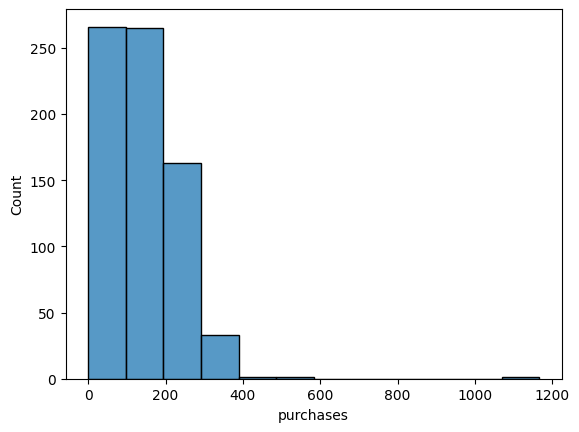

In [ ]:
sns.histplot(pp_day, x= 'purchases', binwidth = 100)

Parece haber un punto claro punto atípico

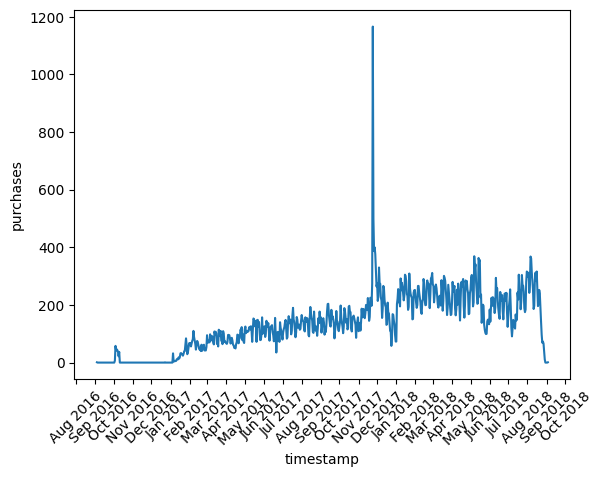

In [ ]:
import matplotlib.dates as mdates

ax = sns.lineplot(data=pp_day, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()



Se ve claramente una subida repentina en noviembre de 2017

In [ ]:
max_p = pp_day.loc[pp_day['purchases'].idxmax()]
max_p.head()

timestamp        2017-11-24 00:00:00
purchases                       1166
total_revenue              178450.11
Name: 446, dtype: object

Viendo que la fecha es el 24 de noviembre de 2017, nos damos cuenta que este outlier es consecuencia directa de black friday, este detalle debe ser tomado en cuenta con la métrica de receny, pues recordando nuestra fecha de referencia (03 de septiembre de 2018), black friday fue hace 290 días, por lo que existe probabilidad de que varios compradores hayan realizado su **última o única** compra en Olist dicho día.

Si quitamos dicho punto atípico

<Axes: xlabel='purchases', ylabel='Count'>

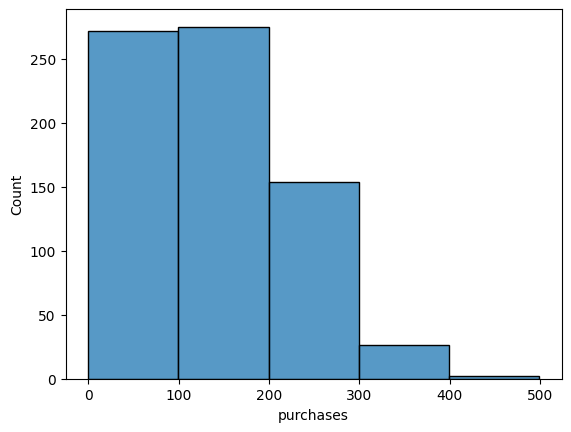

In [ ]:
fix_max_p = pp_day[pp_day['purchases'] != 1166]

sns.histplot(data = fix_max_p, x = 'purchases', binwidth=100)

Si bien ya se ve más normalizado, parece seguir habiendo un punto atípico, si repetimos el proceso de gráfico y máximo

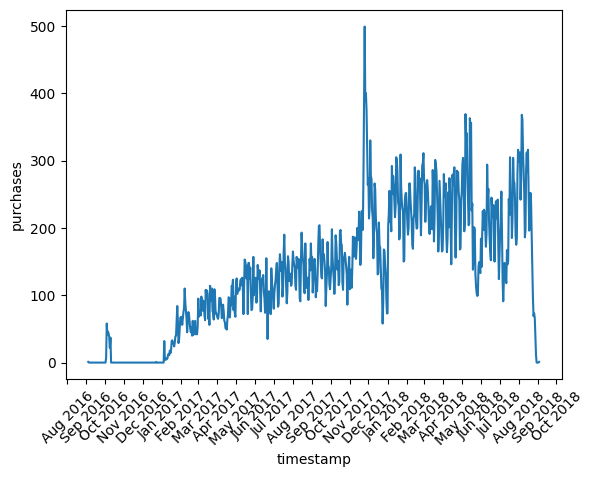

In [ ]:
ax = sns.lineplot(data=fix_max_p, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

Este pico, también en noviembre probablemente sea la continuación del Black Friday, para analizar mejor estos outliers veamos lo 5 días con más ventas

In [ ]:
sorted_purchases = fix_max_p.sort_values(by='purchases',ascending=False)
sorted_purchases.head()

,timestamp,purchases,total_revenue
447,2017-11-25,499,71897.01
449,2017-11-27,400,56644.83
448,2017-11-26,387,53247.48
450,2017-11-28,376,56248.48
610,2018-05-07,369,61418.70


Como era de esperarse, estos encajan perfectamente, con la continuación del Black Friday de 2017, por lo que quitarlos para ver una tendencia "corriente" de la cantidad de compras podría ser adecuado para concluir este análisis

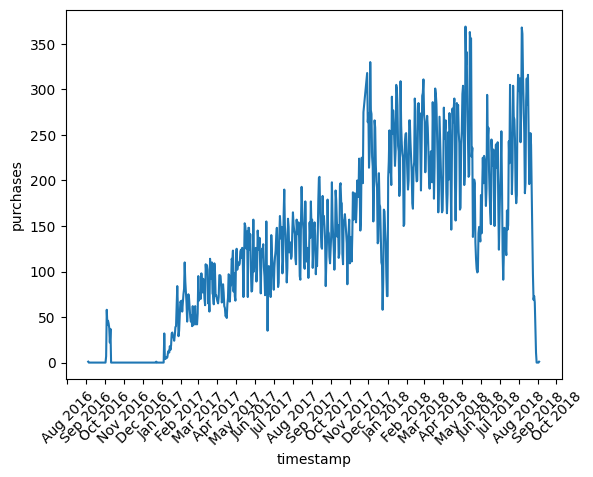

In [ ]:
final_ppd = fix_max_p[fix_max_p['purchases'] < 376].copy()

ax = sns.lineplot(data = final_ppd, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()



Ahora se ve mucho más igualada, el alza de ventas tras cada cierto mes sea muy probablemente por la popularidad que fue adquiriendo Olist. En cuanto la baja de los últimos días probablemente sea más por los datos del dataset, por lo que no se debe tener mucho en cuenta.

### Ganancia por dia

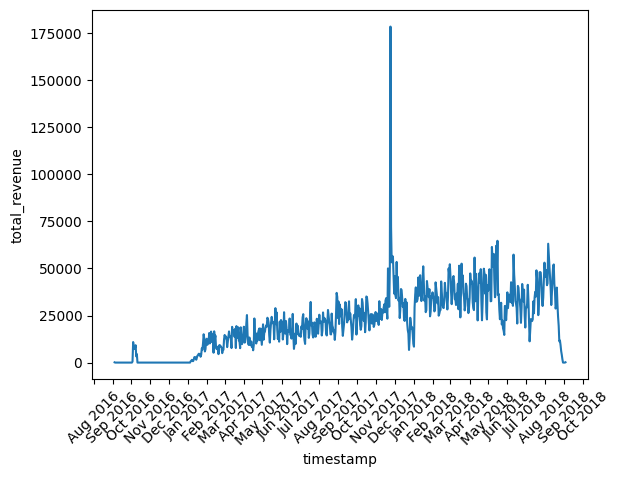

In [ ]:
ax = sns.lineplot(data=pp_day, x='timestamp',y = 'total_revenue')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

## Comparación entre órdenes y ganancias por día

## Análisis de `order_payments`

In [27]:
query = """
SELECT * FROM order_payments
"""
order_payments = pd.read_sql(query,engine)

In [28]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### Valores nulos

In [29]:
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

### Filas duplicadas

In [30]:
order_payments[order_payments.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


### payments_values

In [31]:
query_payment = """
SELECT 
    o.order_id,
    SUM(p.payment_value) AS payment
FROM orders o
JOIN order_payments p ON o.order_id = p.order_id
WHERE p.payment_value > 0 AND o.order_status NOT IN ('canceled','unavailable')
GROUP BY o.order_id
"""

payment = pd.read_sql(query_payment,engine)